In this notebook we'll explore feature importance using SHAP values. SHAP values are the most mathematically consistent way for getting feature importances, and they work particulalry nicely with the tree-based models. Unfortunately, calculating SHAP values is an **extremely** resource intensive process. However, starting with XGBoost 1.3 it is possible to calcualte these values on GPUs, whcih speeds up the process by a factor of 20X - 50X compared to calculating the same on a CPU. Furthermore, it is also possible to calculate SHAP values for feature interactions. The GPU speedup for those is even more dramatic - it takes a few minutes, as opposed to days or even longer on a CPU.

In [1]:
%matplotlib inline


At this point the Kaaggle Docker environment does not support XGBoost 1.3+, so we'll have to install it manually.


In [4]:
!pip install --upgrade xgboost
import xgboost as xgb
xgb.__version__

You should consider upgrading via the 'c:\users\ryans\source\repos\venvs\python375\scripts\python.exe -m pip install --upgrade pip' command.


'1.3.3'

In [55]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import gc
import matplotlib.pyplot as plt
import shap
from scipy import stats

# load JS visualization code to notebook
shap.initjs()

In [ ]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [56]:
train = pd.read_csv('..\\kaggle_data\\train.csv')
test = pd.read_csv('..\\kaggle_data\\test.csv')
sub = pd.read_csv('..\\kaggle_data\\sample_submission.csv')
train = train[(np.abs(stats.zscore(train['target'])) < 3.0)]

In [57]:
columns = test.columns[1:]
columns


Index(['cat0', 'cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat7', 'cat8',
       'cat9', 'cont0', 'cont1', 'cont2', 'cont3', 'cont4', 'cont5', 'cont6',
       'cont7', 'cont8', 'cont9', 'cont10', 'cont11', 'cont12', 'cont13'],
      dtype='object')

In [58]:
target = train['target'].values

Let's applay label encoder to the categorical features.

In [59]:
cat_features = columns[:10]
cat_features

Index(['cat0', 'cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat7', 'cat8',
       'cat9'],
      dtype='object')

In [60]:
for feature in cat_features:
    le = LabelEncoder()
    le.fit(train[feature])
    train[feature] = le.transform(train[feature])
    test[feature] = le.transform(test[feature])

In [61]:
train.head()

,id,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,...,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,target
0,1,0,1,0,0,1,3,0,4,2,...,0.881122,0.421650,0.741413,0.895799,0.802461,0.724417,0.701915,0.877618,0.719903,6.994023
1,2,1,0,0,0,1,1,0,4,0,...,0.440011,0.346230,0.278495,0.593413,0.546056,0.613252,0.741289,0.326679,0.808464,8.071256
2,3,0,0,0,2,1,3,0,1,2,...,0.914155,0.369602,0.832564,0.865620,0.825251,0.264104,0.695561,0.869133,0.828352,5.760456
3,4,0,0,0,2,1,3,0,4,6,...,0.934138,0.578930,0.407313,0.868099,0.794402,0.494269,0.698125,0.809799,0.614766,7.806457
4,6,0,1,0,0,1,1,0,4,2,...,0.382600,0.705940,0.325193,0.440967,0.462146,0.724447,0.683073,0.343457,0.297743,6.868974


In [62]:
test.head()

,id,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,...,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13
0,0,0,1,0,2,1,3,0,4,4,...,0.701679,0.595507,0.286912,0.279884,0.202234,0.242654,0.285147,0.264308,0.653654,0.302448
1,5,0,1,0,2,1,3,0,4,2,...,0.277480,0.479552,0.397436,0.476742,0.857073,0.516393,0.562065,0.730542,0.318492,0.736251
2,15,0,1,0,2,1,3,0,4,2,...,0.279508,0.676395,0.695284,0.253316,0.586934,0.548555,0.836193,0.759788,0.333572,0.273905
3,16,0,0,1,0,1,3,0,4,4,...,0.479503,0.759875,0.240049,0.298074,0.442475,0.596746,0.414131,0.255382,0.589080,0.311625
4,17,0,1,0,0,1,1,0,4,4,...,0.757845,0.210232,0.329851,0.616663,0.170475,0.263235,0.710961,0.224045,0.285860,0.794931


In [63]:
train.shape

(299573, 26)

In [64]:
train_oof = np.zeros((train.shape[0],))
test_preds = 0
train_oof.shape

(299573,)

In [65]:
xgb_params= {
        "objective": "reg:squarederror",
        "max_depth": 6,
        "learning_rate": 0.01,
        "colsample_bytree": 0.4,
        "subsample": 0.6,
        "reg_alpha" : 6,
        "min_child_weight": 100,
        "n_jobs": 2,
        "seed": 42,
        'tree_method': "gpu_hist",
        "gpu_id": 0,
    }

In [66]:
test = xgb.DMatrix(test[columns])

In [67]:
NUM_FOLDS = 10
kf = KFold(n_splits=NUM_FOLDS, shuffle=True, random_state=0)

for f, (train_ind, val_ind) in tqdm(enumerate(kf.split(train, target))):
        #print(f'Fold {f}')
        train_df, val_df = train.iloc[train_ind][columns], train.iloc[val_ind][columns]
        train_target, val_target = target[train_ind], target[val_ind]
        
        train_df = xgb.DMatrix(train_df, label=train_target)
        val_df = xgb.DMatrix(val_df, label=val_target)
        
        model =  xgb.train(xgb_params, train_df, 3600)
        temp_oof = model.predict(val_df)
        temp_test = model.predict(test)

        train_oof[val_ind] = temp_oof
        test_preds += temp_test/NUM_FOLDS
        
        print(mean_squared_error(temp_oof, val_target, squared=False))

1it [00:40, 40.20s/it]

0.8402726582455062


2it [01:19, 39.85s/it]

0.8309217554118459


3it [02:00, 40.15s/it]

0.8395353914682595


4it [02:41, 40.49s/it]

0.8370724757597096


5it [03:21, 40.39s/it]

0.8401260138947114


6it [04:03, 40.94s/it]

0.8385656750737882


7it [04:44, 41.00s/it]

0.8385165172911525


8it [05:24, 40.65s/it]

0.8407448544158622


9it [06:03, 40.15s/it]

0.8296078325690461


10it [06:45, 40.56s/it]

0.8352973515205603


In [16]:
0.8434888431362352

0.8434888431362352

In [68]:
mean_squared_error(train_oof, target, squared=False)


0.8370744216133205

In [69]:
np.save('..\\kaggle_data\\xgb_train_oof', train_oof)
np.save('..\\kaggle_data\\xgb_test_preds', test_preds)
print(train_oof)
print(test_preds)

[7.73171139 7.06704378 7.46401548 ... 7.33323622 7.91703606 7.27282286]
[7.6470847 7.7580476 7.608258  ... 7.5270224 7.4636226 7.3437653]


Next, we calculate the SHAP values for the test set.



In [70]:
%%time
shap_preds = model.predict(test, pred_contribs=True)

Wall time: 15.1 s


Now let's do some plots of these values.

In [71]:
train = pd.read_csv('..\\kaggle_data\\train.csv')
test = pd.read_csv('..\\kaggle_data\\test.csv')
train = train[(np.abs(stats.zscore(train['target'])) < 3.0)]
for feature in cat_features:
    le = LabelEncoder()
    le.fit(train[feature])
    train[feature] = le.transform(train[feature])
    test[feature] = le.transform(test[feature])

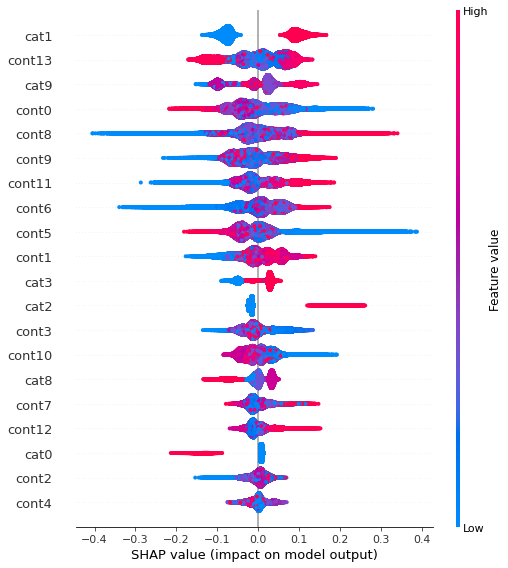

In [72]:
# summarize the effects of all the features
shap.summary_plot(shap_preds[:,:-1], test[columns])

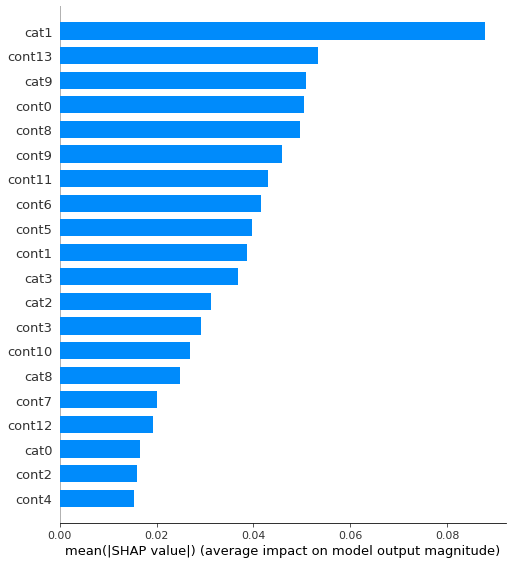

In [73]:
shap.summary_plot(shap_preds[:,:-1], test[columns], plot_type="bar")


Next, we'll calculate SHAP values for featue interactions. There will be 24x24x200,000 + 200,000 numbers that need to be computed.

In [74]:
%%time
shap_interactions = model.predict(xgb.DMatrix(test[columns]), pred_interactions=True)

Wall time: 1min 52s


It took less than 2 minutes to calculate these values. On CPU this would take up to a day to compute.

Now let's take a look at what are the top interactions in this dataset.

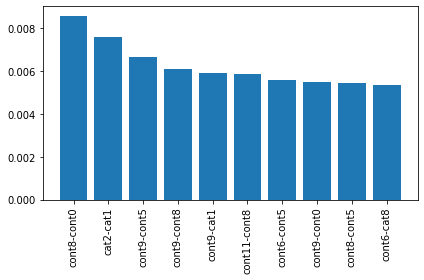

In [75]:
def plot_top_k_interactions(feature_names, shap_interactions, k):
    # Get the mean absolute contribution for each feature interaction
    aggregate_interactions = np.mean(np.abs(shap_interactions[:, :-1, :-1]), axis=0)
    interactions = []
    for i in range(aggregate_interactions.shape[0]):
        for j in range(aggregate_interactions.shape[1]):
            if j < i:
                interactions.append(
                    (feature_names[i] + "-" + feature_names[j], aggregate_interactions[i][j] * 2))
    # sort by magnitude
    interactions.sort(key=lambda x: x[1], reverse=True)
    interaction_features, interaction_values = map(tuple, zip(*interactions))
    plt.bar(interaction_features[:k], interaction_values[:k])
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()
    
plot_top_k_interactions(columns, shap_interactions, 10)


In [76]:
np.unique(train['cat1'])

array([0, 1])

In [77]:
np.unique(train['cat2'])

array([0, 1])

We will now construct 5 more features out of the top 5 most interactive ones.

In [78]:
train['cont8_cont0'] = train['cont8']*train['cont0']
train['cont9_cont0'] = train['cont9']*train['cont0']
train['cont9_cont5'] = train['cont9']*train['cont5']
train['cont8_cont5'] = train['cont8']*train['cont5']
train['cat2_cat1'] = train['cat2']*train['cat1']

test['cont8_cont0'] = test['cont8']*test['cont0']
test['cont9_cont0'] = test['cont9']*test['cont0']
test['cont9_cont5'] = test['cont9']*test['cont5']
test['cont8_cont5'] = test['cont8']*test['cont5']
test['cat2_cat1'] = test['cat2']*test['cat1']

In [79]:
del shap_interactions, shap_preds
gc.collect()
gc.collect()

0

In [80]:
columns = test.columns[1:]
target = train['target'].values
columns

Index(['cat0', 'cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat7', 'cat8',
       'cat9', 'cont0', 'cont1', 'cont2', 'cont3', 'cont4', 'cont5', 'cont6',
       'cont7', 'cont8', 'cont9', 'cont10', 'cont11', 'cont12', 'cont13',
       'cont8_cont0', 'cont9_cont0', 'cont9_cont5', 'cont8_cont5',
       'cat2_cat1'],
      dtype='object')

In [81]:
train_oof_2 = np.zeros((train.shape[0],))
test_preds_2 = 0
train_oof_2.shape

(299573,)

In [82]:
test = xgb.DMatrix(test[columns])

In [83]:
xgb_params= {
        "objective": "reg:squarederror",
        "max_depth": 6,
        "learning_rate": 0.01,
        "colsample_bytree": 0.4,
        "subsample": 0.6,
        "reg_alpha" : 6,
        "min_child_weight": 100,
        "n_jobs": 2,
        "seed": 42,
        'tree_method': "gpu_hist",
        "gpu_id": 0,
    }

In [84]:
NUM_FOLDS = 10
kf = KFold(n_splits=NUM_FOLDS, shuffle=True, random_state=0)

for f, (train_ind, val_ind) in tqdm(enumerate(kf.split(train, target))):
        #print(f'Fold {f}')
        train_df, val_df = train.iloc[train_ind][columns], train.iloc[val_ind][columns]
        train_target, val_target = target[train_ind], target[val_ind]
        
        train_df = xgb.DMatrix(train_df, label=train_target)
        val_df = xgb.DMatrix(val_df, label=val_target)
        
        model =  xgb.train(xgb_params, train_df, 3600)
        temp_oof = model.predict(val_df)
        temp_test = model.predict(test)

        train_oof_2[val_ind] = temp_oof
        test_preds_2 += temp_test/NUM_FOLDS
        
        print(mean_squared_error(temp_oof, val_target, squared=False))

1it [00:46, 46.62s/it]

0.8402739560280479


2it [01:32, 46.34s/it]

0.8310523802332977


3it [02:19, 46.40s/it]

0.8395307742788697


4it [03:05, 46.27s/it]

0.8371561517858787


5it [03:51, 46.41s/it]

0.8402553615155054


6it [04:38, 46.35s/it]

0.8386220292574575


7it [05:24, 46.27s/it]

0.8383289592741111


8it [06:10, 46.20s/it]

0.840832511713968


9it [06:56, 46.14s/it]

0.8295412231168677


10it [07:42, 46.29s/it]

0.8355867759610396


In [85]:
mean_squared_error(train_oof_2, target, squared=False)


0.8371263545083387

In [86]:
def multichoose(n,k):
    if k < 0 or n < 0: return "Error"
    if not k: return [[0]*n]
    if not n: return []
    if n == 1: return [[k]]
    return [[0]+val for val in multichoose(n-1,k)] + \
        [[val[0]+1]+val[1:] for val in multichoose(n,k-1)]

In [87]:
weights_cluster = np.array(multichoose(2,10))/10

best_score = 100
best_weight = []

for w in weights_cluster:
    score = mean_squared_error(w[0]*train_oof+w[1]*train_oof_2, target, squared=False)
    if score < best_score:
        best_score = score
        best_weight = w
        
print(best_weight)


[0.6 0.4]


In [88]:
np.save('..\\kaggle_data\\xgb_train_oof_with_shap', train_oof_2)
np.save('..\\kaggle_data\\xgb_test_preds_with_shap', test_preds_2)
print(train_oof)
print(test_preds)

[7.73171139 7.06704378 7.46401548 ... 7.33323622 7.91703606 7.27282286]
[7.6470847 7.7580476 7.608258  ... 7.5270224 7.4636226 7.3437653]


In [89]:
sub['target'] = best_weight[0]*test_preds+best_weight[1]*test_preds_2
from datetime import datetime
dt_string = datetime.now().strftime("%d-%m-%Y_%H-%M-%S")

sub.to_csv(f'..\\kaggle_data\\{dt_string}_submission.csv', index=False)

In [53]:
sub

,id,target
0,0,7.645183
1,5,7.755115
2,15,7.602802
3,16,7.459246
4,17,7.308489
...,...,...
199995,499987,7.522983
199996,499990,7.272247
199997,499991,7.530863
199998,499994,7.458135


Now let's see what are the SHAP values for this model

In [42]:
%%time
shap_preds = model.predict(test, pred_contribs=True)

Wall time: 15.4 s


In [44]:
train = pd.read_csv('..\\kaggle_data\\train.csv')
test = pd.read_csv('..\\kaggle_data\\test.csv')
train = train[(np.abs(stats.zscore(train['target'])) < 3.0)]
for feature in cat_features:
    le = LabelEncoder()
    le.fit(train[feature])
    train[feature] = le.transform(train[feature])
    test[feature] = le.transform(test[feature])
    
train['cont8_cont0'] = train['cont8']*train['cont0']
train['cont9_cont0'] = train['cont9']*train['cont0']
train['cont9_cont5'] = train['cont9']*train['cont5']
train['cont8_cont5'] = train['cont8']*train['cont5']
train['cat2_cat1'] = train['cat2']*train['cat1']

test['cont8_cont0'] = test['cont8']*test['cont0']
test['cont9_cont0'] = test['cont9']*test['cont0']
test['cont9_cont5'] = test['cont9']*test['cont5']
test['cont8_cont5'] = test['cont8']*test['cont5']
test['cat2_cat1'] = test['cat2']*test['cat1']
columns = test.columns[1:]

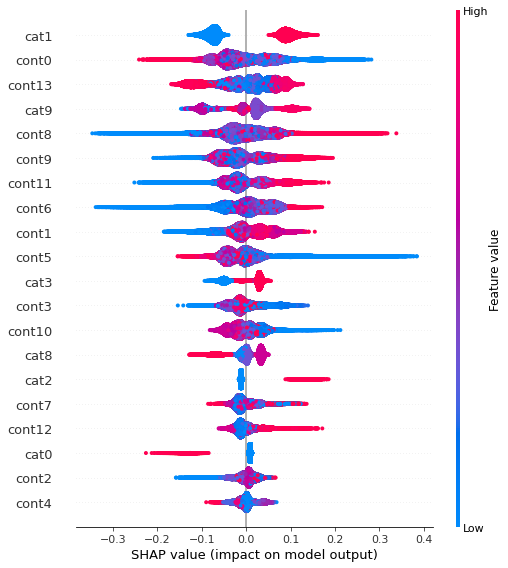

In [45]:
# summarize the effects of all the features
shap.summary_plot(shap_preds[:,:-1], test[columns])

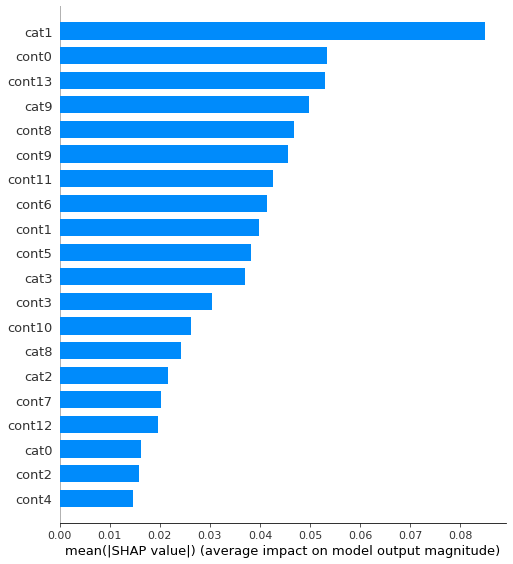

In [46]:
shap.summary_plot(shap_preds[:,:-1], test[columns], plot_type="bar")


In [ ]:
sub['target'] = best_weight[0]*test_preds_lgb+best_weight[1]*test_preds_xgb
sub.to_csv('submission.csv', index=False)

In [41]:
sub['target'] = test_preds
sub.to_csv('submission.csv', index=False)

In [42]:
sub['target'] = test_preds_2
sub.to_csv('submission_2.csv', index=False)

In [43]:
sub['target'] = 1.1*test_preds-0.1*test_preds_2
sub.to_csv('submission_average_0.csv', index=False)

In [44]:
sub['target'] = 1.2*test_preds-0.2*test_preds_2
sub.to_csv('submission_average_1.csv', index=False)

In [45]:
sub['target'] = 1.3*test_preds-0.3*test_preds_2
sub.to_csv('submission_average_2.csv', index=False)